# OWA Dudgeon Array Efficiency: Benchmark Evaluation Script

## Introduction
This is the model evaluation script for the [OWA-Dugeon Array Efficiency benchmark](https://thewindvaneblog.com/owa-wake-modelling-challenge-extended-to-6-offshore-wind-farms-c76d1ae645c2), following the same benchmark guidelines as the [OWA-Anholt benchmark](https://thewindvaneblog.com/the-owa-anholt-array-efficiency-benchmark-436fc538597d), as part of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).

## Load libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants
This dictionary defines the simulations submitted to the benchmark and provides the following flags:

* ***Plot***: identifies which simulations will be included in the assessment 
* ***Highlight***: identifies which simulations will be highlighted in the plots
* ***Ensemble***: identifies which simulations will be included in the model ensemble
* ***Save***: identifies which simulations will be saved for the multi-site assessment 

The ensemble is used as a consensus model when observations are not available and the main objective is to identify which simulations deviate too much from the mean. During the blind test phase of the OWA Challenge, the main difference between models was whether they would use heterogeneous (*wt*) or homogeneous (*ref*) inflow. Hence, we decided to include in the ensemble those that were already implementing heterogeneous inflow, being a more realistic setting for large offshore wind farms.    

In [3]:
sims = pd.read_csv('./outputs/Dudgeon_sims.csv')
n_sim = len(sims)
ensemble = sims.index[sims['Ensemble'] == 1].tolist()
plotresults = sims.index[sims['Plot'] == 1].tolist()
highlight = sims.index[sims['Highlight'] == 1].tolist()
tags = 'Label' # we use this column from the dictionary to identify simulations
sims.style.set_properties(**{'text-align': 'center'})

,ID,Plot,Highlight,Ensemble,Save,Participant Number,Participant,Model Name,Model Type,Approach,Input,External Gradients,Inflow,Remarks,Label
0,ensemble,1,1,0,1,23,ensemble,ensemble,ensemble,ba,"wakes,wt",meso,wt,,ensemble
1,dud00a,1,0,0,1,0,CENER,FLORIS,Porté-Agel-Neutral,ts,"wakes,ref",meso,ref,Neutral,0_CENER_PortéAgelNeutral_wakes_ref
2,dud00b,1,0,0,1,0,CENER,FLORIS,Jensen-Neutral,ts,"wakes,ref",meso,ref,Neutral,0_CENER_JensenNeutral_wakes_ref
3,dud00c,1,0,0,1,0,CENER,FLORIS,Multizone-Neutral,ts,"wakes,ref",meso,ref,Neutral,0_CENER_MultizoneNeutral_wakes_ref
4,dud01a,1,0,1,0,1,PPE,WakeBlaster,RANS Eddy-Viscosity,ts,"ctrl,wt",micro,wt,Race Bank and Sherinham Shoal added,1_PPE_WakeBlaster_ctrlWF_wt
5,dud01b,1,1,1,1,1,PPE,WakeBlaster,RANS Eddy-Viscosity,ts,"wakes,wt",meso,wt,,1_PPE_WakeBlaster_wakes_wt
6,dud01c,1,0,0,0,1,PPE,WakeBlaster,RANS Eddy-Viscosity,ts,"ctrl,wt",micro,wt,,1_PPE_WakeBlaster_ctrl_wt
7,dud01d,1,1,0,0,1,PPE,WakeBlaster,RANS Eddy-Viscosity,ts,"wakes-corr,wt",meso-corr,wt,,1_PPE_WakeBlaster_wakes-corr_wt
8,dud02a,1,0,0,0,2,TU-Delft,eWakeLab,PARK83,ts,"ctrl,wt",none,wt,K = 0.04,2_TUD_PARK83_ctrl_wt
9,dud02b,1,1,1,1,2,TU-Delft,eWakeLab,PARK83,ts,"wakes,wt",meso,wt,K = 0.04,2_TUD_PARK83_K0.04_wakes_wt


## Input Data
### Wind Farm Input Data 
We load the layout characteristics and wind turbine power curve. The layout centroid is our reference (*ref*) position to define the wind conditions that will be used for binning the wind climate into wind direction and stability classes. The coordinates of the turbines are defined using the *ref* position as origin. 

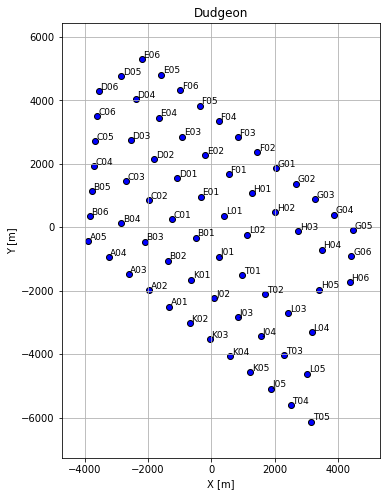

In [4]:
# setup
datefrom = time_stamp(2017,12,1,0,0,0)    # evaluation period
dateto = time_stamp(2018,11,30,23,0,0)    

siteID = 'Dudgeon'
Hhub = 110.          # hub-height
Drot = 154.          # rotor diameter
z_ref = Hhub         # [m]

# Load power curve 
pwr_curve_file = pd.read_csv('./inputs/Dudgeon_pwc.csv')
pwr_curve_file['Power'] = pwr_curve_file['Power']/1000 # scale to MW
pwr_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['Power'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
Ct_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['Ct'].values.flatten(), 
                                bounds_error = False, fill_value = 0)

# Load wind farm layout data
turbines = pd.read_csv("inputs/Dudgeon_layout.csv")
x_ref, y_ref = centroid(turbines[['X coordinate','Y coordinate']].values) # coordinates of wind farm centroid
x_wt = turbines['X coordinate']-x_ref
y_wt = turbines['Y coordinate']-y_ref
wt_label = turbines['VDC ID']
plot_wf_layout(x_wt, y_wt,[],labels = wt_label, title = siteID, figsize=(12,8));

#### Flags for Validation in Nominal Conditions
The scada_flags dataframe indicates which registers in the SCADA data have been modified in the quality-control process. To increase the data availability, a machine learning algorithm has been applied to recover data from turbines that are not working in nominal conditions from others that do. Since the SCADA data comes in 10-min intervals but we want to work with hourly data, we indicate in each hourly timestamp how many 10-min samples have been corrected (e.g. 1/6 indicates that one 10-min interval has been gap-filled and the other 5 are ok). This allows to perform the evaluation on a dataset which only contains situations where the wind farm is operating in normal conditions. This file is provided to the participants so they can compute their bin-averages using the same timestamps of the validation data. Notice that:

* $min\_data\_availability$ sets the minimum availability of original (non-reconstructed) observational data, i.e. for 90%, no more than 10% is reconstructed.

* $scada\_ts$ list the time stamps that will be retained in the analysis

In [5]:
scada_flags = pd.read_csv('./inputs/Dudgeon_flags.csv', index_col = 'Datetime') 
Ntot = scada_flags.shape[0]     # total number of samples in the scada dataset
min_data_availability = 90
scada_ts = flags_to_ts(scada_flags, min_data_availability) # generate a list of accepted time series

print("Hence, after applying the filter we get %d hourly samples, which is %.2f%% of the original data" % (scada_ts.shape[0],scada_ts.shape[0]*100/Ntot))

Hence, after applying the filter we get 6146 hourly samples, which is 70.15% of the original data


### Mesoscale Input Data
We load the input mesoscale data interpolated at the turbine positions. 
* ***Control (mesoctrl)***: free of mesoscale wake effects
* ***Wakes (mesowk)***: mesoscale wake effects from neighbouring farms included in the simulation (but not the target wind farm)
* ***Wakes Corrected (mesocorr)***: *Wakes* simulation corrected for mesoscale bias using bin-averaged correction factors ($A_m$). This is discussed later. 

In the absence of an *undisturbed* met mast, the wind farm centroid (*ref*) is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. The *ref* conditions have been obtained by averaging the wind conditions from all turbines. Hence, it represents a spatial average of the wind climate of equal size as the wind farm layout. This site has also been used as the center of the innermost domain in the WRF set-up.

The power curve is used to transform the input wind speed into gross power. This will later be used in the definition of array efficiency.

In [6]:
# Load mesoscale input data 
fctrl = './inputs/Dudgeon_Control_WindTurbines.nc'
S_mesoctrl_ts = read_input(fctrl,datefrom,dateto,scada_ts,'S')
P_mesoctrl_ts = S_mesoctrl_ts.transform(pwr_curve)
S_mesoctrl_ts.columns = turbines['VDC ID'].values # the wt label should come from the nc file
P_mesoctrl_ts.columns = turbines['VDC ID'].values

fwakes = './inputs/Dudgeon_Wakes_WindTurbines_corrected.nc'
S_mesowk_ts, S_mesocorr_ts = read_input(fwakes,datefrom,dateto,scada_ts,['S','S_corr'])
P_mesowk_ts = S_mesowk_ts.transform(pwr_curve)
P_mesocorr_ts = S_mesocorr_ts.transform(pwr_curve)
S_mesocorr_ts.columns = turbines['VDC ID'].values
P_mesocorr_ts.columns = turbines['VDC ID'].values
S_mesowk_ts.columns = turbines['VDC ID'].values
P_mesowk_ts.columns = turbines['VDC ID'].values

# Load ref conditions at wind farm centroid 
fref = './inputs/Dudgeon_Wakes_ref_corrected.nc'
S_ref_ts, WD_ref_ts, zL_ref_ts = read_input(fref,datefrom,dateto,scada_ts,['S','WD','zL'])
ref_ts = pd.concat([S_ref_ts, WD_ref_ts, zL_ref_ts], axis=1, names=['S_ref', 'WD_ref', 'zL_ref'])
ref_ts.columns = ['S', 'WD', 'zL']

### Bin-averaged Wind Conditions
Here we define how the wind distribution is categorized in bins. We focus on one wind speed bin for which the thrust coefficient is at its maximum in order to have the strongest wake effects. Then, wind direction and stability are divided according to *WDbins* and *zLbins* at the reference site. The input time series for wind speed and gross power are converted into bin tables with dimmensions {$wt$: turbine position, $wd$: wind direction sector, $zL$: stability class}. 
* *binmap* provides datetime indices to the samples that will be included in each bin
* N_WDzL counts the number of samples in each bin

../src/BinAvrg.py:1144: RuntimeWarning: invalid value encountered in greater
  x[x>WDbins[-1]] = x[x>WDbins[-1]]-360


After filtering for the wind speed, stability and direction bins, there are 834 hourly samples (9.52% of the original data) distributed according to the following validation bins:


<Figure size 1296x576 with 0 Axes>

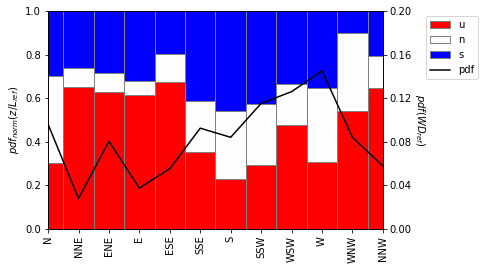

In [7]:
# Define bins to classify wind conditions 
Sbins = np.array([8,10])              # around the maximum of the trust coefficient 
WDbins = np.arange(-15.,360.+15.,30)  # wind direction bins (12 sectors)
WDbins_label = np.array(['N','NNE','ENE','E','ESE','SSE',
                         'S','SSW','WSW','W','WNW','NNW'])
zLbins = np.array([-0.2,-0.02, 0.02, 0.2])      # 3 stability bins
zLbins_label = np.array(['u','n','s'])

bins_label = [wt_label.values, WDbins_label, zLbins_label]

# Filter wind speed bin and leave out large stabilities
indexS = ref_ts[(ref_ts['S'] >= Sbins[0]) & (ref_ts['S'] <= Sbins[1])
            & (ref_ts['zL'] > zLbins[0]) & (ref_ts['zL'] < zLbins[-1])].index

# Apply filters
ref_ts = ref_ts.reindex(scada_ts).reindex(indexS)
S_mesoctrl_ts = S_mesoctrl_ts.reindex(scada_ts).reindex(indexS)
P_mesoctrl_ts = P_mesoctrl_ts.reindex(scada_ts).reindex(indexS)
S_mesowk_ts = S_mesowk_ts.reindex(scada_ts).reindex(indexS)
P_mesowk_ts = P_mesowk_ts.reindex(scada_ts).reindex(indexS)
S_mesocorr_ts = S_mesocorr_ts.reindex(scada_ts).reindex(indexS)
P_mesocorr_ts = P_mesocorr_ts.reindex(scada_ts).reindex(indexS)

# Compute bin-averaged quantities 
N_WDzL, binmap = WDzL_bins(ref_ts['WD'],ref_ts['zL'],ref_ts['S'],'count',[WDbins, zLbins],bins_label,plot = True);
Nval = N_WDzL.sum().sum() # total number of samples in the validation dataset
print("After filtering for the wind speed, stability and direction bins, there are %d hourly samples (%.2f%% of the original data) distributed according to the following validation bins:" % (Nval, Nval*100/Ntot));

S_mesowk, S_mesowk_std = bin_avrg(S_mesowk_ts, binmap, bins_label)
P_mesowk, P_mesowk_std = bin_avrg(P_mesowk_ts, binmap, bins_label)
S_mesoctrl, S_mesoctrl_std = bin_avrg(S_mesoctrl_ts, binmap, bins_label)
P_mesoctrl, P_mesoctrl_std = bin_avrg(P_mesoctrl_ts, binmap, bins_label)
S_mesocorr, S_mesocorr_std = bin_avrg(S_mesocorr_ts, binmap, bins_label)
P_mesocorr, P_mesocorr_std = bin_avrg(P_mesocorr_ts, binmap, bins_label)

## Simulation Data
We load the simulations defined in *sims* and produce bin tables of net power.  

In [8]:
P, P_std = read_sims(sims,binmap,bins_label)

## Validation Data
The "gap-filled" observational data is loaded and the *scada_ts* filter applied to syncronize with the simulation data for validation.

In [9]:
P_obs, P_obs_std, validation_data = read_obs('./observations/Dudgeon_obs.csv',binmap,bins_label)

Here we select which dataset is used as *benchmark* to compute the error metrics. If no validation data is available, do code-to-code comparison by selecting a reference simulation to compare against. In the blind test we select the model ensemble as benchmark.

In [10]:
validation = True # "False" if no validation data is available or you want to do code-to-code comparison 
benchmark = 0      # benchmark simulation for code-to-code (ensemble = 0) 

P_bench, P_bench_std = define_benchmark(validation, validation_data, benchmark, P_obs, P_obs_std, P, P_std, sims)

You are doing validation against observations


## Input Bias
### Mesoscale Bias 
The input mesoscale data comes with an inherent bias that we can try to mitigate by using local observations. In the absence of a met mast, the power data can serve as a proxy to obtain the wind resource through the inverse of the power curve. This is done at the turbines that experience *freestream* conditions at the boundary of the array, which depends on the wind direction. The *define_freestream(points,WD)* function uses the reference wind direction and determines which turbines in the wind farm boundary do not have upstream wind turbines within a 45º sector. Turbines inside the array are associated with the wind resource of the nearest turbine in free-stream conditions. Then, a mesoscale bias correction factor is defined at each turbine location, $A_{M,i}$, as the ratio between the observed freestream power $P_{obsfree,i}$ and that simulated from mesoscale $P(S_i)$:  

$$ A_{M,i} = \frac{P_{obsfree,i}}{P(S_{i})} \sim \left( \frac{S_{obs,i}}{S_{i}} \right)^{3} $$

These correction factors are applied to the *mesowk* mesoscale data to obtain *mesocorr* bias-corrected input data. Unfortunately, the observed freestream time-series (*Pfree_obs*) are not publicly available. 

Total mesoscale bias correction = 0.892


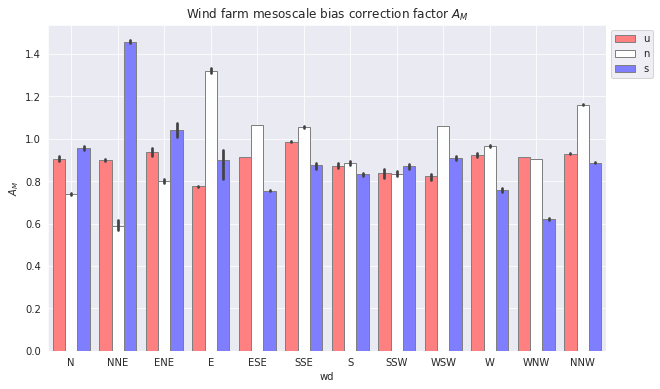

In [11]:
Am, Pfree_obs, _ = Ameso('./observations/Dudgeon_Pfree.csv', N_WDzL, binmap, bins_label,
                                            P_mesowk,'Dudgeon_Am.nc',plot = True, figsize = (10,6))

This bin has 41.0 samples


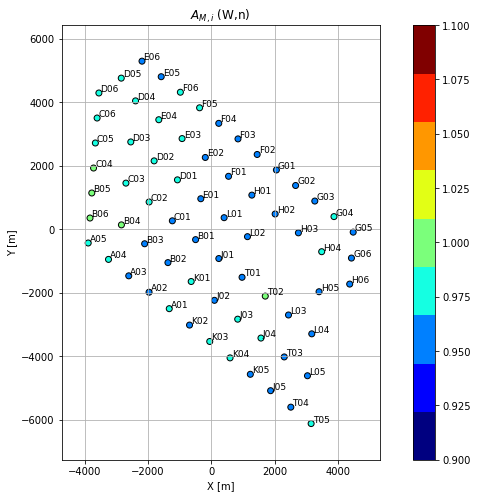

In [12]:
# Show mesoscale bias for a bin
WDbin = 'W' # select wind direction sector
zLbin = 'n'   # select stability

print('This bin has {} samples'.format(N_WDzL.loc[WDbin,zLbin]))
title = r'$A_{M,i}$ ('+ WDbin + ',' + zLbin + ')'
plot_wf_layout(x_wt, y_wt, data = Am.loc[:,WDbin,zLbin].to_pandas(), labels = wt_label, 
               vmin = 0.9,vmax = 1.1, cmap = 'jet', title = title, figsize = (12,8));

### Horizontal Wind Resource Gradients 
Horizontal gradients are calculated for each bin in two ways: 
* As a power ratio, by taking the difference between the maximum and minimum gross power and dividing by the mean

$$ \Delta P_{gross} = \frac{max(P(S_i)) - min(P(S_i))}{mean(P(S_i))} $$

* As a normalized wind speed gradient, by least-squares fit of turbine wind speed and rotating to a wind direction coordinate system ($S_u$, $S_v$). It is normalized by dividing by $S/L_u$, where $L_u$ is the wind farm length.



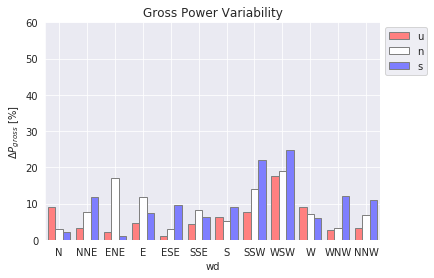

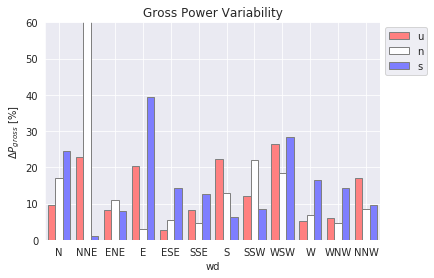

In [13]:
# Compute gross power variability
Pdelta = 100.*(P_mesowk.max(axis = 0) - P_mesowk.min(axis = 0))/P_mesowk.mean(axis = 0)
#Pdelta = 100.*(P_mesocorr.max(axis = 0) - P_mesocorr.min(axis = 0))/P_mesocorr.mean(axis = 0)
Pdelta_obs = 100.*(Pfree_obs.max(axis = 0) - Pfree_obs.min(axis = 0))/Pfree_obs.mean(axis = 0)
plot_gradient(Pdelta, var = 'P', figsize = (6,4), ylim = [0,60])
plot_gradient(Pdelta_obs, var = 'P', figsize = (6,4), ylim = [0,60])

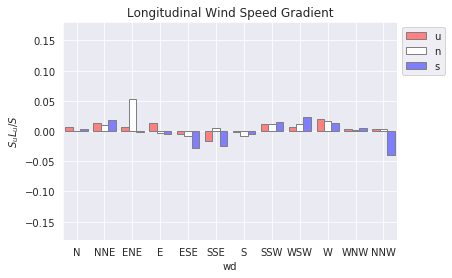

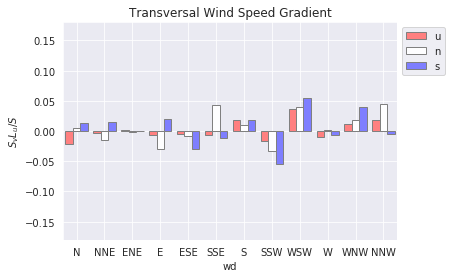

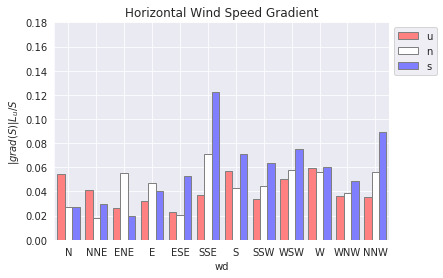

In [14]:
# Compute horizontal wind speed gradients along (Su) and across (Sv) the wind direction 
U_mesowk_ts, V_mesowk_ts = read_input(fwakes,datefrom,dateto,scada_ts,['U','V'])
U_mesowk_ts.columns = turbines['VDC ID'].values
V_mesowk_ts.columns = turbines['VDC ID'].values

Sh_mesowk_ts = S_grad(x_wt,y_wt,U_mesowk_ts,V_mesowk_ts,coord = 'wd')
Sh_mesowk_ts = Sh_mesowk_ts.reindex(scada_ts).reindex(indexS)
Su, _ = bin_avrg(Sh_mesowk_ts['Su'], binmap, [WDbins_label, zLbins_label])
Sv, _ = bin_avrg(Sh_mesowk_ts['Sv'], binmap, [WDbins_label, zLbins_label])
Sh, _ = bin_avrg(Sh_mesowk_ts['Sh'], binmap, [WDbins_label, zLbins_label])

plot_gradient(Su, var = 'u', figsize = (6,4), ylim = (-0.18, 0.18))
plot_gradient(Sv, var = 'v', figsize = (6,4), ylim = (-0.18, 0.18))
plot_gradient(Sh, var = 'h', figsize = (6,4), ylim = (0    , 0.18))

### Gross Power and Freestream Bias
These corrections depend on our ability to infer the freestream wind speed from the observations of Power. We can quantify how much we deviate from the *true* freestream wind speed by applying the "freestream" method to the mesoscale simulations ($P_{free,i}$) and then comparing this proxy with the simulated freestream wind speed ($P(S_{i})$).  

$$ A_{free,i} = \frac{P_{free,i}}{P(S_{i})} \sim \left( \frac{S_{free,i}}{S_{i}} \right)^{3} $$


In [15]:
# Wind farm gross power based on mesoscale inputs 
P_mesowk_sum = np.sum(P_mesowk, axis = 0)       # mesoscale "wakes"
P_mesoctrl_sum = np.sum(P_mesoctrl, axis = 0)   # mesoscale "control"
P_mesocorr_sum = np.sum(P_mesocorr, axis = 0)   # bias-corrected mesoscale "wakes"

# Gross power from scada using define_freestream method 
Pfree_obs_sum = np.sum(Pfree_obs, axis = 0)     # observations 

# Gross power using define_freestream method and compute freestream power and Afree for each simulation
P_gross = {"ctrl": P_mesoctrl,"wakes": P_mesowk, "wakes-corr": P_mesocorr, "scada": Pfree_obs}
Pfree, Afree = Afreestream(P_gross,P,sims,[WDbins, zLbins],bins_label,turbines)

This bin has 20.0 samples


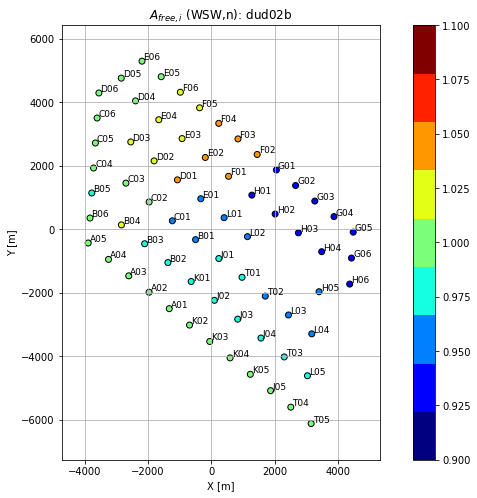

In [16]:
# Print freestream bias for a bin
sim = 'dud02b' # select simulation to plot
WDbin = 'WSW' # select wind direction sector
zLbin = 'n'   # select stability

print('This bin has {} samples'.format(N_WDzL.loc[WDbin,zLbin]))
title = r'$A_{free,i}$ ('+ WDbin + ',' + zLbin + '): ' + sim
plot_wf_layout(x_wt, y_wt, data = Afree.loc[sim,:,WDbin,zLbin].to_pandas(), labels = wt_label,
               vmin = 0.9,vmax = 1.1, cmap = 'jet', title = title, figsize = (12,8));

Total freestream bias correction = 0.990


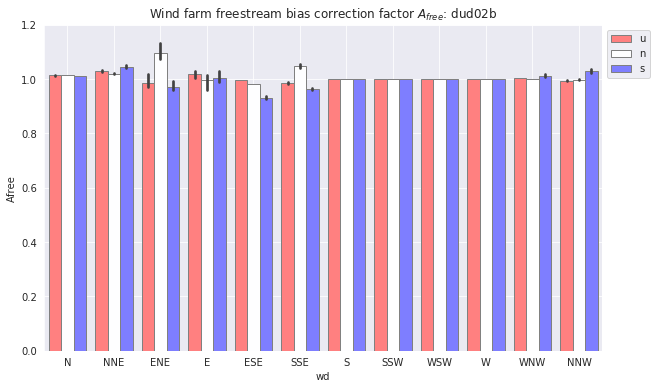

In [17]:
plot_Afree(Afree,sim,N_WDzL,zLbins_label); 

## Compute Quantities of Interest and Metrics
*Array efficiency* for a wind turbine is defined as:

$$ \eta_{i} = \frac{P_i}{P(S_i)} $$

and for the whole wind farm as: 

$$ \eta = \frac{P}{P_{free}} = \frac{\sum_{i}P_i}{\sum_{i}P(S_i)} $$

where $P_i$ is the power of turbine $i$, observed or simulated, and $P(S_i)$ is the theoretical power from the power curve computed at the corresponding input wind speed $S_i$ at each turbine position.  

Performance is measured in terms of the $BIAS$ and mean absolute error ($MAE$):

$$ BIAS = \eta_{sim} - \eta_{bench} $$ 
$$ MAE = |\eta_{sim} - \eta_{bench}| $$

where the benchmark data come from either observations or another simulation (typically the ensemble). The metrics are calculated for each turbine and wind farm per bin and integrated for the whole wind distribution. Hence:
* Positive *BIAS* means over-prediction of array efficiency, i.e. the model predicts smaller wake losses 
* Negative *BIAS* means under-prediction of array efficiency, i.e. the model predeicts larger wake losses
* *MAE* avoids the error compensation that takes place in the *BIAS* 

In [18]:
# Array efficiency for each turbine and for the wind farm
eta = 100*P/Pfree
eta_farm = 100*np.sum(P, axis = 1) / np.sum(Pfree, axis = 1)

# Benchmark to compute metrics against 
if (validation and validation_data):      # when observations are available
    eta_bench = 100*P_bench / Pfree_obs    
    eta_bench_farm = 100*np.sum(P_bench, axis = 0) / np.sum(Pfree_obs, axis = 0) 
else:  # benchmark simulation
    eta_bench = eta[benchmark]    
    eta_bench_farm = eta_farm[benchmark]
    
# Compute metrics
bias = eta - eta_bench
bias_farm = eta_farm - eta_bench_farm
mae = np.absolute(bias)
mae_farm = np.absolute(bias_farm)

## Results

### Overall Metrics
We integrate array efficiency over all the bins with more than *Nmin* samples, i.e. bins with less than *Nmin* samples will be given zero weight in the summation over all bins.

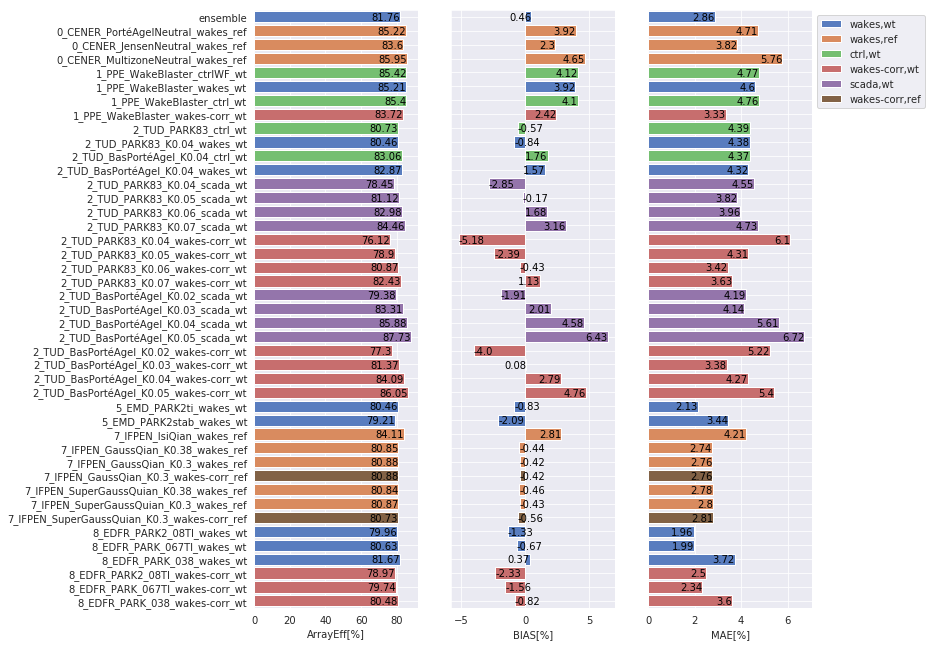

In [19]:
Nmin = 25
metrics = overall_metrics(eta_farm, bias_farm, mae_farm, sims, N_WDzL,
                                  Nmin, binmap, tags, figsize = (10,11), plot = True)
#metrics.iloc[plotresults]

### Bin-averaged Metrics
Let's see which bins have the largest bias. We have masked those bins with less than $N_{min}$ samples. The rest show the mean bias, which is not weighted-averaged by the bin count. 

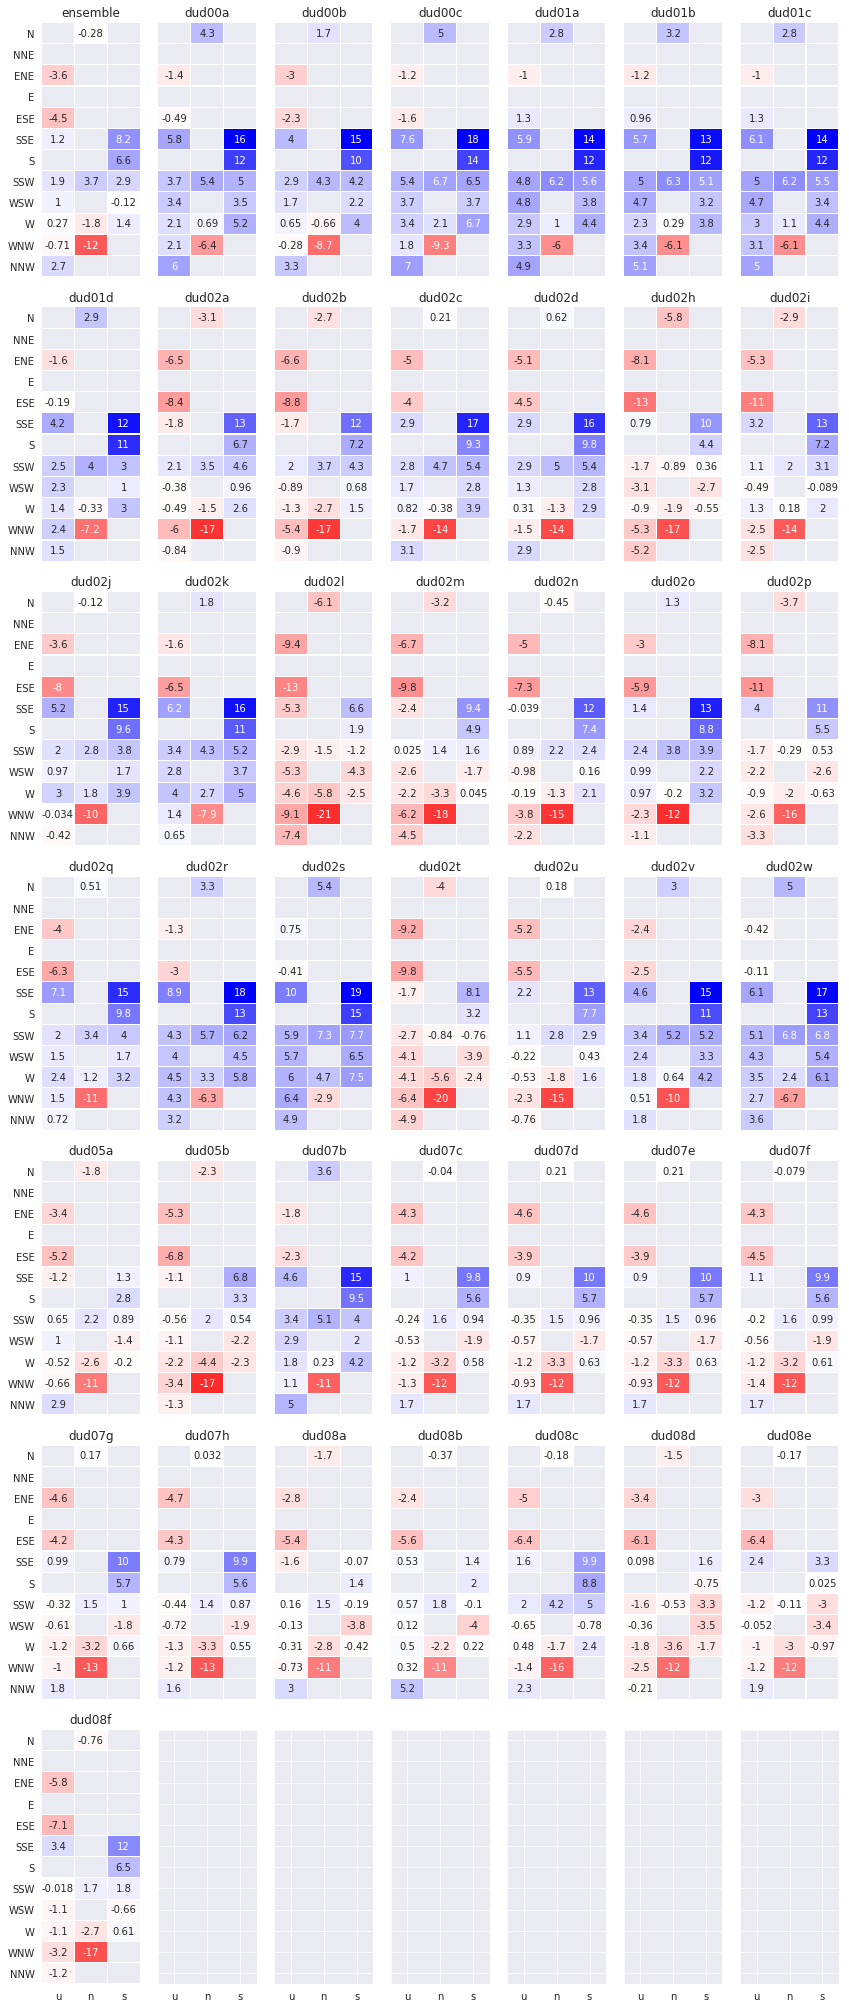

In [20]:
plot_heatmaps(bias_farm, sims, N_WDzL, Nmin, ax_size = (1.7,4), cols = 7)

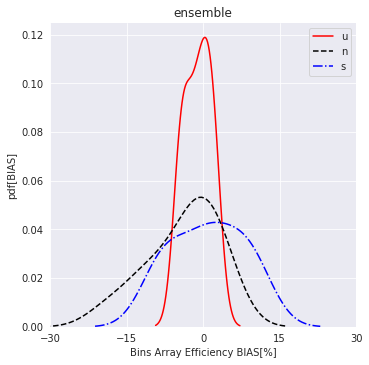

In [21]:
# Distribution of turbine errors 
sim = 'ensemble' # select simulation to plot
bias_wf = bias_farm.loc[sim]
bias_wf_stacked = bias_wf.stack(z=('wd','zL')).to_dataframe('BIAS[%]')
bins_wf_stacked = bias_wf_stacked.reset_index(level=[0,1]).drop(['sim'], axis = 1)
bins_wf_stacked = bins_wf_stacked.reset_index()

d = {'color': ['r', 'k', 'b'], 'ls' : ['-','--','-.']}
with sns.axes_style("darkgrid"):
    ax1 = sns.FacetGrid(bins_wf_stacked, hue='zL', height = 5, hue_kws=d)
    ax1 = (ax1.map(sns.kdeplot, "BIAS[%]",shade=False))
    ax1 = (ax1.set_axis_labels("Bins Array Efficiency BIAS[%]", "pdf[BIAS]")
          .set(xlim=(-30, 30),xticks=[-30,-15,0,15,30]))
    plt.title(sim)
    plt.legend()

### Stability-Based Metrics
Integrate over all wind directions to obtain mean metrics vs stability.  

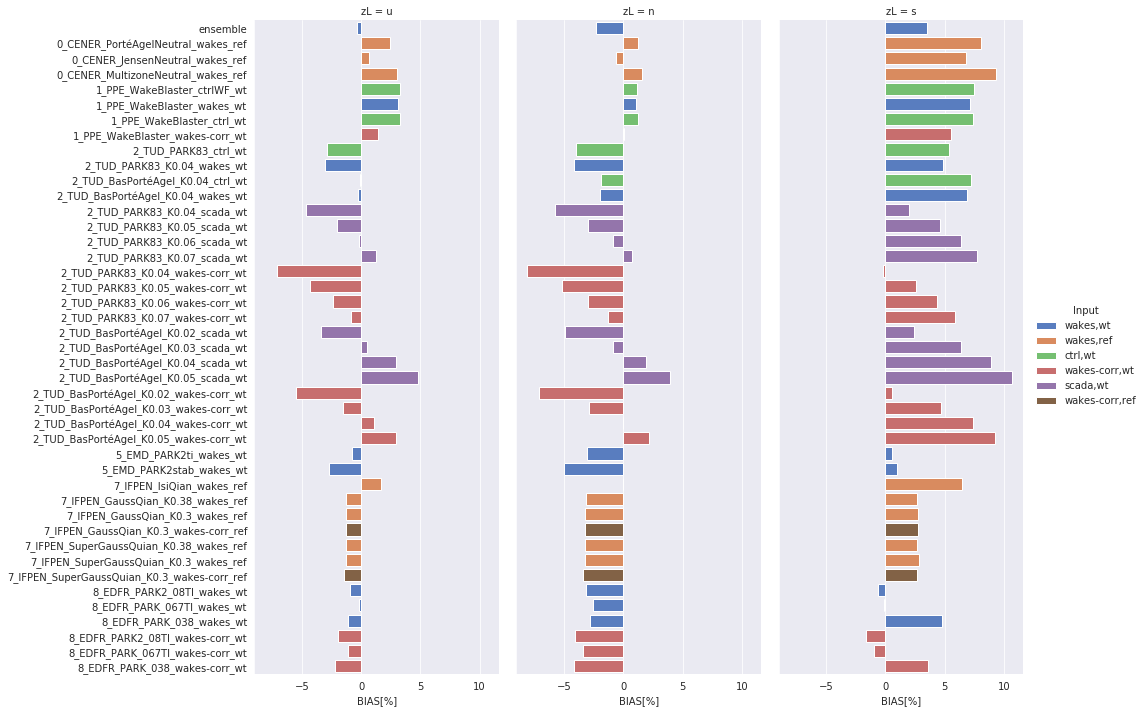

In [22]:
bias_farm_zL = stability_metrics(bias_farm,sims,"BIAS[%]",N_WDzL,Nmin,binmap,tags,figsize = (10,0.5), plot = True)

### Integration Along Wind Direction and Stability 
Integrate along wind direction and stability dimensions to assess array efficiency variability versus layout characteristics and sensitivity to stability conditions. Beware of bins with low sample count that may be subject to lack of statistical convergence. 

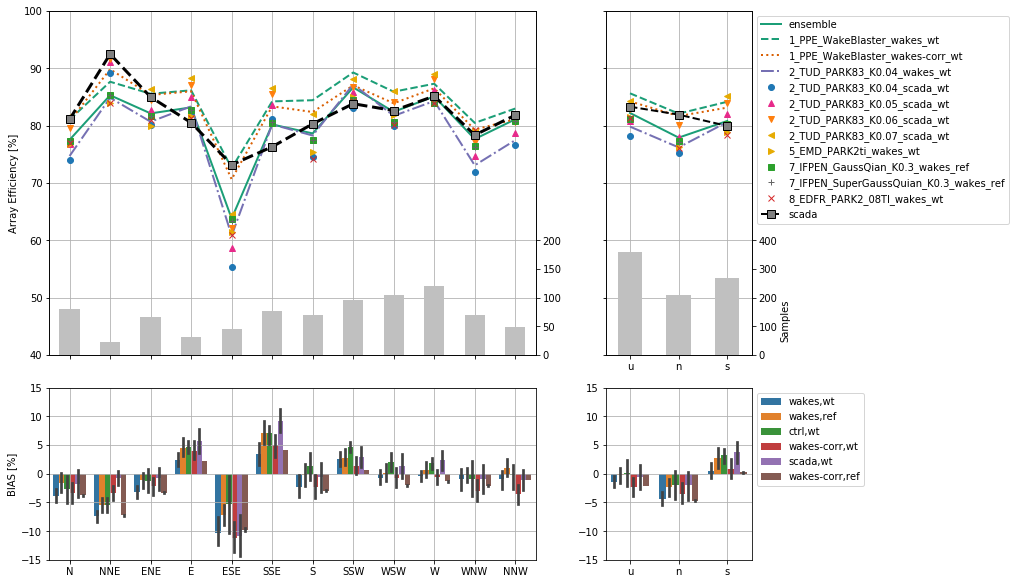

In [23]:
plot_eta_WD_zL(eta_farm, bias_farm, eta_bench_farm, sims, N_WDzL, validation, plot_type = 'highlight');

### Wind Turbine Metrics

Select a simulation and compare with the reference dataset (observations or another simulation).


This bin has 20.0 samples


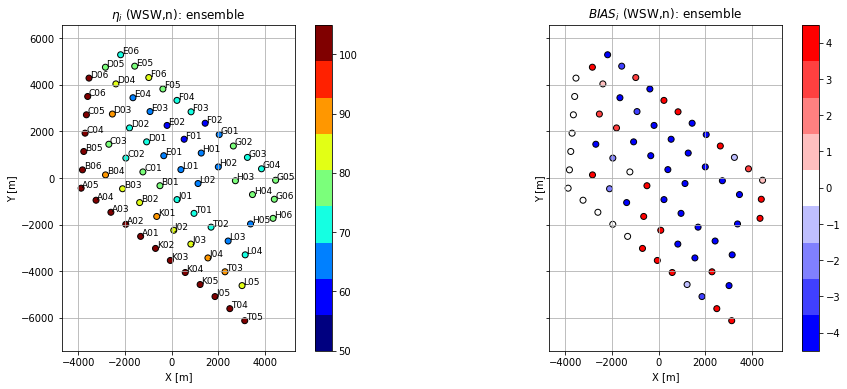

In [32]:
sim = 'ensemble' # select simulation to plot
WDbin = 'WSW' # select wind direction sector
zLbin = 'n'   # select stability

print('This bin has {} samples'.format(N_WDzL.loc[WDbin,zLbin]))
f, (ax1, ax2) = plt.subplots(1, 2 , sharey=True, figsize=(16,6))
title = r'$\eta_{i}$ ('+ WDbin + ',' + zLbin + '): ' + sim
plot_wf_layout(x_wt, y_wt, data = eta.loc[sim,:,WDbin,zLbin].to_pandas(), labels = wt_label,
               vmin = 50.,vmax = 105., cmap = 'jet', title = title, figsize = (12,8), ax = ax1);
title = r'$BIAS_{i}$ ('+ WDbin + ',' + zLbin + '): ' + sim
plot_wf_layout(x_wt, y_wt, data = bias.loc[sim,:,WDbin,zLbin].to_pandas(), labels = [],
               vmin = -4.5,vmax = 4.5, cmap = 'bwr', title = title, figsize = (12,8), ax = ax2);

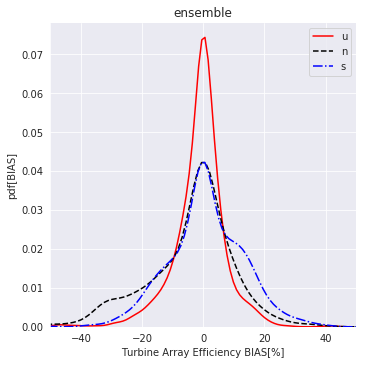

In [25]:
# Distribution of turbine errors 
sim = 'ensemble' # select simulation to plot
bias_wt = bias.loc[sim]
bias_wt_stacked = bias_wt.stack(z=('wt', 'wd','zL')).to_dataframe('BIAS[%]')
bins_wt_stacked = bias_wt_stacked.reset_index(level=[0,1]).drop(['sim'], axis = 1)
bins_wt_stacked = bins_wt_stacked.reset_index()

d = {'color': ['r', 'k', 'b'], 'ls' : ['-','--','-.']}
with sns.axes_style("darkgrid"):
    ax1 = sns.FacetGrid(bins_wt_stacked, hue='zL', height = 5, hue_kws=d)
    ax1 = (ax1.map(sns.kdeplot, "BIAS[%]",shade=False))
    ax1 = (ax1.set_axis_labels("Turbine Array Efficiency BIAS[%]", "pdf[BIAS]")
          .set(xlim=(-50, 50),xticks=[-40,-20,0,20,40]))
    plt.title(sim)
    plt.legend()

**Plot a transect, for chosen bin and list of wind turbines**

Here you can choose a wind direction and stability bin and analyze array efficiency along a given transect. It can be compared with the **gross power ratio**, which is defined as the free-stream at each turbie divided by the power at the reference position (the average of all the wind farm). 

$$ GPR_{i} = \frac{P_{gross,i}}{P_{gross,ref}} $$

This bin has 50.0 samples


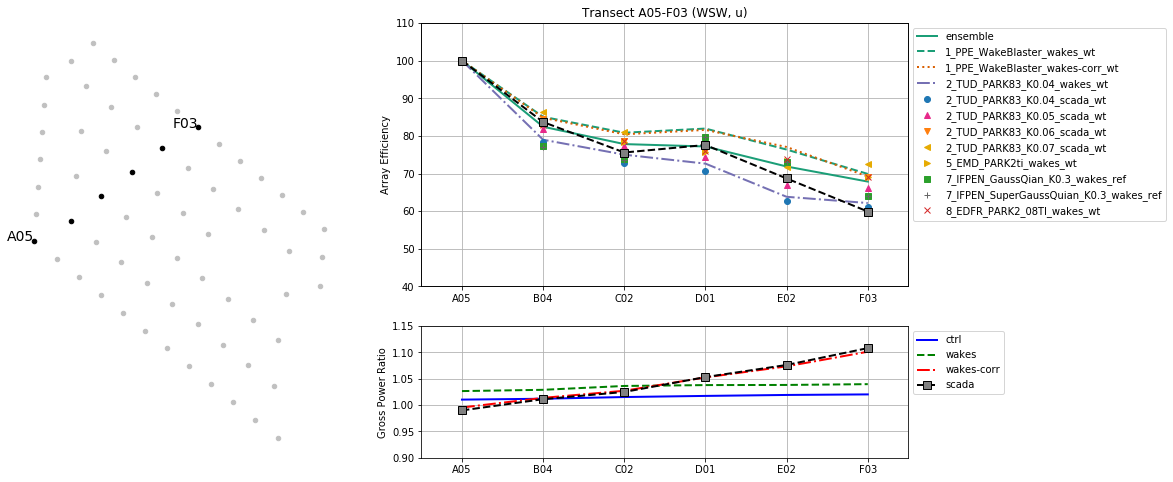

In [31]:
WDbin = 'WSW'
zLbin = 'u'

#wt_list = ['C04','C03','C02','C01','B01','J01','T01','T02','L03','L04']
#wt_list = ['A03','B03','C01','E01','F01','F02']
#wt_list = ['A02','B02','B01','L01','H01','G01']
wt_list = ['A05','B04','C02','D01','E02','F03']

plot_transect(eta,eta_bench,P_gross,WDbin,zLbin,wt_list,turbines,sims,plotresults,highlight,validation,
              ylim1 = [40,110],ylim2 = [0.9,1.15],figsize = (16,8), plot_type = 'highlight');
print('This bin has {} samples'.format(N_WDzL.loc[WDbin,zLbin]))

## Save Results
Save results for the multi-site assessment. Only simulations flagged with *Save = 1* will be saved to the */results* folder.

In [33]:
saveresults = False
resultspath = './results/'

if saveresults == True:
    sims_save_index = sims[sims['Save'] == 1].index
    sims.iloc[sims_save_index].to_csv(resultspath + siteID + '_sims.csv')
    Nwt, Nwd, NzL = [len(dim) for dim in bins_label]
    # Overall Metrics
    overall_results = pd.concat([sims.iloc[sims_save_index], metrics.iloc[sims_save_index].drop(['sim','Input'], axis = 1)], axis = 1)
    overall_results.to_csv(resultspath + siteID + '_overall.csv')
    
    # Bin Metrics
    bins_stacked = eta_farm[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('ArrayEff[%]')
    bins_stacked.loc[:,'BIAS[%]'] = bias_farm[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('BIAS[%]')
    bins_stacked.loc[:,'MAE[%]'] = mae_farm[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('MAE[%]')

#    addvariable = eta_bench_farm.expand_dims({'sim':n_sim}).assign_coords(sim = sims['ID'].values)
#    bins_stacked.loc[:,'ArrayEff_obs[%]'] = addvariable[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('ArrayEff[%]')
    
    addvariable = Sh.expand_dims({'sim':n_sim}).assign_coords(sim = sims['ID'].values)
    bins_stacked.loc[:,'Sh'] = addvariable[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('S_h')

    addvariable = Su.expand_dims({'sim':n_sim}).assign_coords(sim = sims['ID'].values)
    bins_stacked.loc[:,'Su'] = addvariable[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('S_u')

    addvariable = Sv.expand_dims({'sim':n_sim}).assign_coords(sim = sims['ID'].values)
    bins_stacked.loc[:,'Sv'] = addvariable[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('S_v')

    addvariable = Pdelta.expand_dims({'sim':n_sim}).assign_coords(sim = sims['ID'].values)
    bins_stacked.loc[:,'dP'] = addvariable[sims_save_index].stack(z=('sim', 'wd','zL')).to_dataframe('dP')

    bins_stacked = bins_stacked.reset_index(level=[0,1,2]).drop(['sim'], axis = 1)
    sims_stacked = pd.concat([sims.iloc[sims_save_index]]*Nwd*NzL).sort_index().drop(['Plot','Highlight','Ensemble','Save'],axis = 1)
    sims_stacked = sims_stacked.reset_index()
    
    # add bin sample count
    df = N_WDzL.T.reset_index() 
    df = pd.melt(df, id_vars = 'index', value_vars = WDbins_label)
    df = pd.concat([df]*len(sims_save_index)).reset_index()
    bins_stacked['N'] = df['value'] 
    
    bins_results = pd.concat([sims_stacked, bins_stacked], axis = 1)
    bins_results.to_csv(resultspath + siteID + '_bins.csv')